In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
import os

if 'google.colab' in sys.modules:
    
    ! git clone https://github.com/tikendraw/chatbot-with-attention.git 
    os.chdir('chatbot-with-attention') 
    print(os.getcwd())

    ! pip install tensorflow==2.11 -q
    ! pip install tensorflow-text -q

Cloning into 'chatbot-with-attention'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 40 (delta 2), reused 33 (delta 1), pack-reused 0
Unpacking objects: 100% (40/40), 35.00 MiB | 7.21 MiB/s, done.
/content/chatbot-with-attention
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 87.3 MB/s eta 0:00:00


In [3]:

import seaborn as sns
import random, os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, GRU, Bidirectional, TimeDistributed, Dense, Attention, MultiHeadAttention
import tensorflow_text as tf_text
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import CSVLogger

print('GPU Avaliable: ', gpu:=len(tf.config.list_physical_devices('GPU')))
if gpu:
    pass



GPU Avaliable:  1


In [4]:
DEBUG = False

if DEBUG:
    pass
else:
    pass

In [5]:
data = pd.read_csv('./dataset.csv',sep = '\t',encoding='latin1', names = ['col1','col2'])

In [6]:
# show the data
data.head()

,col1,col2
0,Can we make this quick? Roxanne Korrine and A...,"Well, I thought we'd start with pronunciation,..."
1,"Well, I thought we'd start with pronunciation,...",Not the hacking and gagging and spitting part....
2,Not the hacking and gagging and spitting part....,Okay... then how 'bout we try out some French ...
3,You're asking me out. That's so cute. What's ...,Forget it.
4,"No, no, it's my fault -- we didn't have a prop...",Cameron.


In [7]:
# check for null values
data.isnull().sum()

col1    0
col2    0
dtype: int64

In [8]:
# senetence lenght of conversations
data['col1_length'] = data.col1.apply(lambda x: len(str(x).split()))
data['col2_length'] = data.col2.apply(lambda x: len(str(x).split()))

In [9]:
data.head()

,col1,col2,col1_length,col2_length
0,Can we make this quick? Roxanne Korrine and A...,"Well, I thought we'd start with pronunciation,...",22,12
1,"Well, I thought we'd start with pronunciation,...",Not the hacking and gagging and spitting part....,12,9
2,Not the hacking and gagging and spitting part....,Okay... then how 'bout we try out some French ...,9,12
3,You're asking me out. That's so cute. What's ...,Forget it.,11,2
4,"No, no, it's my fault -- we didn't have a prop...",Cameron.,13,1


In [10]:

def distplot_axis(x:np.array, axis:list=list(range(95,100)), percent:int = 99,where_text:int = 5000,xlim:list=None, ylim:list=None, **kwargs):
    # plt.figure(figsize = (15,7))
    plt.grid()

    plt.hist(x , bins = 50, **kwargs)
    # Title Word Count distribution
    try:
        plt.xlim(xlim[0], xlim[1])
        plt.ylim(ylim[0], ylim[1])
    except:
        pass

    plt.xlabel('word length')
    plt.ylabel('Count')
    for i in axis:
        plt.axvline(x = np.percentile(x, i), color = 'b', label = 'axvline - full height')
        # random_pixel = 
        try:
            plt.text(np.percentile(x, i),where_text,f'{i} percent',rotation=90)
        except:
            pass

    plt.title(f'Text Word Count distribution: {np.percentile(x, percent)} words cover {percent}% of text data')



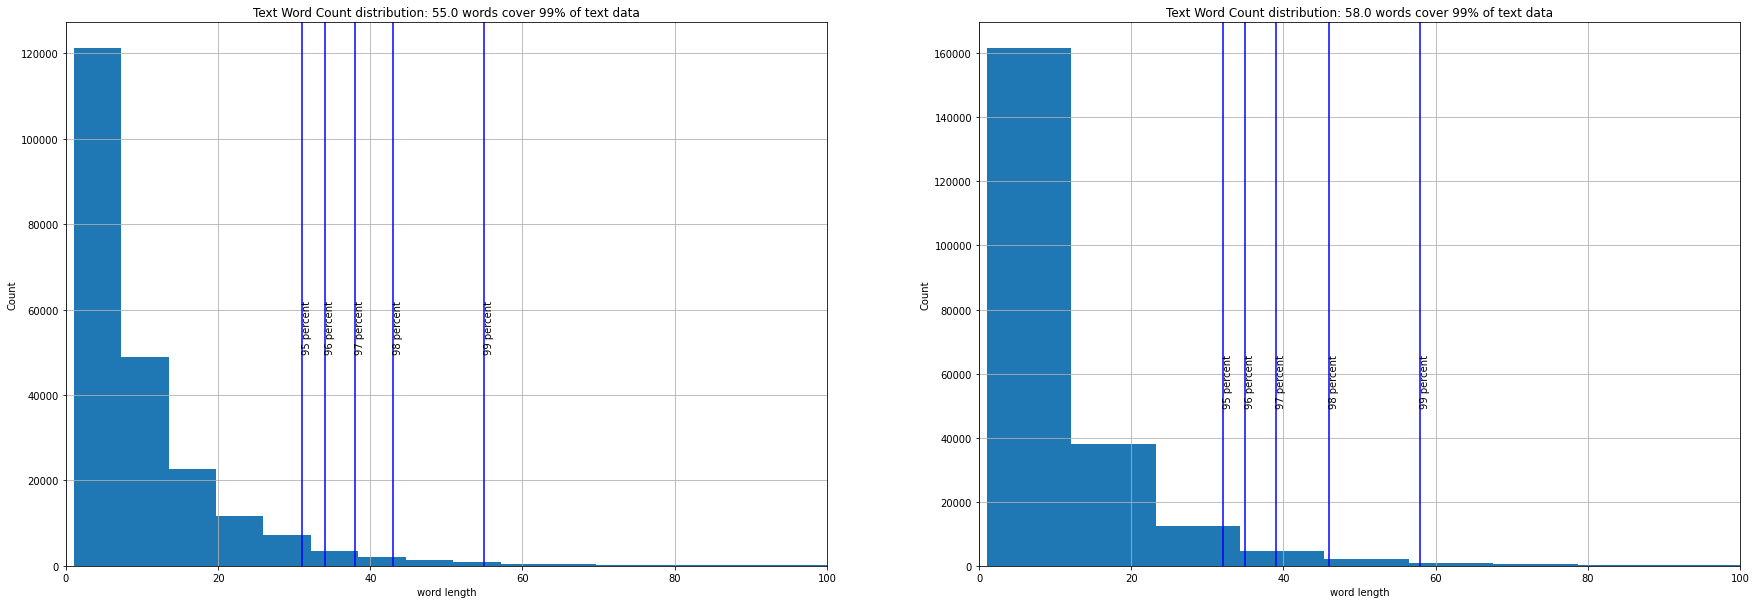

In [11]:
plt.figure(figsize = (30,10))

plt.subplot(1,2,1)
distplot_axis(data.col1_length,where_text = 50000, xlim=[0,100])


plt.subplot(1,2,2)
distplot_axis(data.col2_length,where_text = 50000, xlim=[0,100])

In [12]:
MAX_OUTPUT_LENGTH = 102
BATCH_SIZE = 32
UNITS = 64
EMBEDDING_DIMS = 128

# Splitting Data

In [13]:
if DEBUG:
    xtrain, xtest, ytrain, ytest = train_test_split(data['col1'],data['col2'], train_size=.05 , test_size=.005, random_state= 44)
else:
    xtrain, xtest, ytrain, ytest = train_test_split(data['col1'],data['col2'], test_size=.05, random_state= 44)

In [14]:
print(f'{xtrain.shape=}')
print(f'{ytrain.shape=}')
print(f'{xtest.shape=}')
print(f'{ytest.shape=}')

xtrain.shape=(210217,)
ytrain.shape=(210217,)
xtest.shape=(11065,)
ytest.shape=(11065,)


In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((xtrain.to_list(), ytrain.to_list()))
test_data = tf.data.Dataset.from_tensor_slices((xtest.to_list(), ytest.to_list()))

# Text Vectorization

In [15]:
# preprocessing text
def tf_lower_and_split_punct_en(text):
    # Split accented characters.
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿|]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text



In [ ]:
# vectorization
vectorizer = TextVectorization(output_sequence_length=MAX_OUTPUT_LENGTH, standardize=tf_lower_and_split_punct_en)

In [ ]:
for i,j in train_data.take(1):
    print(i)
    print(j)

tf.Tensor(b'is bending down, pulling a tray of sausage rolls into the oven. Both girls look at HONORA silently.', shape=(), dtype=string)
tf.Tensor(b'turns around and Juliet presents her with a brown paper bag.', shape=(), dtype=string)


In [ ]:

# 20.2 s ± 606 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# 21* 7 == 2 MIN 27 sec
vectorizer.adapt(xtrain)

### saving vectorizer
https://stackoverflow.com/questions/65103526/how-to-save-textvectorization-to-disk-in-tensorflow


In [ ]:
# Pickle the config and weights

# os.makedirs('components', exist_ok=True)
# pickle.dump({'config': vectorizer.get_config(),
#              'weights': vectorizer.get_weights()}
#             , open("./components/vectorizer.pkl", "wb"))


### Loading saved vectorizer

In [16]:
# Later you can unpickle and use 
# `config` to create object and 
# `weights` to load the trained weights. 

from_disk = pickle.load(open("./components/vectorizer.pkl", "rb"))
vectorizer = TextVectorization.from_config(from_disk['config'])
# You have to call `adapt` with some dummy data (BUG in Keras)
vectorizer.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
vectorizer.set_weights(from_disk['weights'])

# Lets see the Vector for word "this"
print (vectorizer("who am i"))

tf.Tensor(
[  3  76 144   8   4   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0], shape=(102,), dtype=int64)


In [ ]:
def make_vector(x, y):
    x = vectorizer(x)
    y = vectorizer(y)

    x = x[:-1]
    y_in = y[:-1]
    y_out = y[1:]
    return (x,y_in),y_out

In [ ]:
train_data = train_data.map(make_vector).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(make_vector).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Saving the Dataset

In [17]:
# %%timeit

save_train_data_path = './dataset/train/'
save_test_data_path = './dataset/test/'

# # save the train_data and test_data
# train_data.save(save_train_data_path, compression='GZIP')
# test_data.save(save_test_data_path, compression='GZIP')

In [18]:
#loading the data
train_data = tf.data.Dataset.load(save_train_data_path, compression='GZIP')
test_data = tf.data.Dataset.load(save_test_data_path, compression='GZIP')

In [19]:
for (enc_input, dec_input), dec_output  in train_data.take(1):
    print('encoder input')
    print(enc_input[0, :20].numpy())
    print('-'*44)
    print('decoder input')
    print(dec_input[0, :20].numpy()) 
    print('-'*44)
    print('encoder output')
    print(dec_output[0, :20].numpy())
    break

encoder input
[    3    20 10942   120     5  1994    11  6126    14  9357  5660   154
     9  7211     2   443   532   105    61 11786]
--------------------------------------------
decoder input
[   3 1361  174   13 3319 4872   69   39   11 1415  764  922    2    4
    0    0    0    0    0    0]
--------------------------------------------
encoder output
[1361  174   13 3319 4872   69   39   11 1415  764  922    2    4    0
    0    0    0    0    0    0]


# Encoder

In [91]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_vectorizer, units, embed_dims):
        super(Encoder, self).__init__()
        self.text_vectorizer =  text_vectorizer
        self.units = units
        self.embed_dims = embed_dims
        self.vocab_size = text_vectorizer.vocabulary_size()
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embed_dims, mask_zero=True, )
        self.rnn = Bidirectional(merge_mode='concat', layer = GRU(self.units, return_sequences=True, return_state=True))
        
    def call(self, x, y=None, return_state=False):
        
        x = self.embedding(x)
        encoder_output, encoder_fw_state, encoder_bw_state = self.rnn(x)
        encoder_state = [encoder_fw_state, encoder_bw_state]
        
        if return_state:
            return encoder_output, encoder_state
        else:
            return encoder_output
        
    def convert_input(self, texts, return_state=False):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.text_vectorizer(texts)
        
        context = self(context, return_state = return_state)
        
        return context

In [92]:
encoder = Encoder(vectorizer, UNITS, EMBEDDING_DIMS)

In [93]:
en_context , en_state = encoder(enc_input, return_state = True)

In [23]:
print('context',en_context.shape)
print('state fw',en_state[0].shape)
print('state bw',en_state[1].shape)

context (32, 101, 128)
state fw (32, 64)
state bw (32, 64)


# Attention Layer

In [24]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x, context):

        attn_output, attn_scores = self.mha(
            query=x,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        attn_scores = tf.reduce_mean(attn_scores, axis=1)
        self.last_attention_weights = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [25]:
# attention = tf.keras.layers.Attention()
# score = attention([en_context, en_context], return_attention_scores=True)

In [26]:
attention = CrossAttention(UNITS)
score = attention(en_context, en_context)

In [27]:
if len(score)==2:
    print(score[0].shape);print(score[1].shape)
else:
    print(score.shape)

(32, 101, 128)


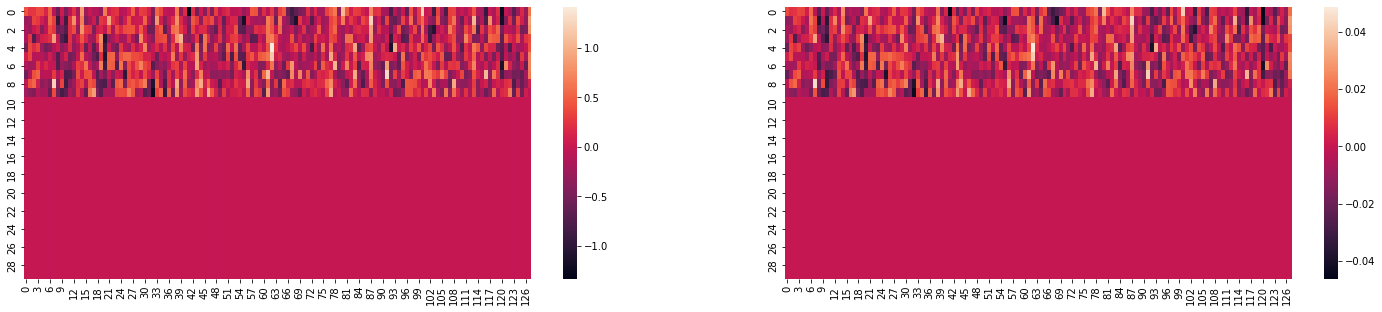

In [28]:
# score[0,:,:], en_context[0,:,:]
random_num = random.randint(0,32)
plt.figure(figsize = (25,5))

try:
    plt.subplot(1,2,1)
    sns.heatmap(score[random_num,:30,:])

#     # attention score
#     plt.subplot(1,3,2)
#     sns.heatmap(score[1][random_num,:30,:])

    # encoder output
    plt.subplot(1,2,2)
    sns.heatmap(en_context[random_num,:30,:])
    
except:
    pass

# Decoder

In [33]:
class Decoder(keras.layers.Layer):
    def __init__(self, text_vectorizer, units,  embed_dims) :
        super(Decoder, self).__init__()
        self.text_vectorizer =  text_vectorizer
        self.units = units
        self.embed_dims = embed_dims
        self.vocab_size = text_vectorizer.vocabulary_size()
        
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embed_dims, mask_zero=True, )
        self.rnn = GRU(self.units, return_sequences=True, return_state=True)
        
        # self.attention =  tf.keras.layers.Attention()
        self.attention = CrossAttention(units)
        
        self.output_dense = Dense(self.vocab_size)
        
        self.word_to_id = tf.keras.layers.StringLookup(vocabulary=text_vectorizer.get_vocabulary(), mask_token='', oov_token='[UNK]')
        self.id_to_word = tf.keras.layers.StringLookup(vocabulary=text_vectorizer.get_vocabulary(), mask_token='', oov_token='[UNK]', invert=True)
        
        self.start_token = self.word_to_id('[START]')
        self.end_token = self.word_to_id('[END]')

    def call(self, x, context, state=None, return_state = False):
        ''' x, context, state=None, return_sequence=False '''
        
        x = self.embedding(x)
        
        decoder_output, decoder_state = self.rnn(x, initial_state=state)
        
        # decoder_state = [decoder_state_h, decoder_state_c]
        x = self.attention(decoder_output, context)
        self.last_attention_weights = self.attention.last_attention_weights

        logits = self.output_dense(x)
        
        if return_state:
            return logits, decoder_state
        else:
            return logits
        
    def get_initial_state(self, context):
        batch_size = tf.shape(context)[0]
        start_tokens = tf.fill([batch_size, 1], self.start_token)
        done = tf.zeros([batch_size, 1], dtype=tf.bool)
        embedded = self.embedding(start_tokens)
        return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

    
    def tokens_to_text(self, tokens):
        words = self.id_to_word(tokens)
        result = tf.strings.reduce_join(words, axis=-1, separator=' ')
        result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
        result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
        return result
    
    def get_next_token(self, next_token, context,  done, state, temperature = 0.0):
        
        logits, state = self(next_token, context, state = state, return_state=True) 

        if temperature == 0.0:
            next_token = tf.argmax(logits, axis=-1)
        else:
            logits = logits[:, -1, :]/temperature
            next_token = tf.random.categorical(logits, num_samples=1)

        # If a sequence produces an `end_token`, set it `done`
        done = done | (next_token == self.end_token)
        # Once a sequence is done it only produces 0-padding.
        next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

        return next_token, done, state

In [34]:
decoder = Decoder(vectorizer, UNITS, EMBEDDING_DIMS)

In [36]:
dec_out = decoder(dec_output, en_context, return_state = True)

In [38]:
len(dec_out), type(dec_out)

(2, tuple)

In [37]:
print(f'decoder logits shape: {dec_out[0].shape}')
print(f'decoder state h shape: {dec_out[1][0].shape}')
print(f'decoder state c shape: {dec_out[1][1].shape}')

decoder logits shape: (32, 101, 49580)
decoder state h shape: (64,)
decoder state c shape: (64,)


# Model

In [39]:
class ChatBot(tf.keras.Model):
    
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, text_processor, units, embed_dims):
        super().__init__()
        self.text_processor = text_processor
        self.units = units
        self.embed_dims = embed_dims
        
        # Build the encoder and decoder
        encoder = Encoder(text_processor, units, embed_dims)
        decoder = Decoder(text_processor, units, embed_dims)
        
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        logits = self.decoder(x, context)

        #TODO(b/250038731): remove this
        try:
          # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
            del logits._keras_mask
        except AttributeError:
            pass

        return logits


In [94]:
model = ChatBot(vectorizer, UNITS, EMBEDDING_DIMS)

# logits = model((enc_input, dec_input))

# print(f'Context tokens, shape: (batch, s, units) {enc_input.shape}')
# print(f'Target tokens, shape: (batch, t) {dec_input.shape}')
# print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

# Masked Loss and Accuracy

In [95]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [96]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

# Compile and Train

In [97]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [98]:
# The model is randomly initialized, and should give roughly uniform output probabilities. 
# So it's easy to predict what the initial values of the metrics should be:


vocab_size = 1.0 * vectorizer.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": f'{1/vocab_size:.7f}'}

{'expected_loss': 10.811343, 'expected_acc': '0.0000202'}

In [99]:
# model.evaluate(test_data, steps=20, return_dict=True)

In [100]:
EPOCHS = 10

# CKPT_DIR = './model_checkpoint'
CKPT_DIR = '/content/drive/MyDrive/tf_model/chatbot'
os.makedirs(CKPT_DIR, exist_ok = True)
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(CKPT_DIR,  f"{datetime.now().strftime('%m:%d:%Y, %H:%M:%S')}"),
    monitor= 'masked_acc',
    verbose= 0,
    save_best_only = True,
    save_weights_only = True,
    mode= 'auto',
    save_freq='epoch'
)

os.makedirs('log', exist_ok = True)
csv_logger = CSVLogger('./log/training.log')


In [101]:
# Train
history = model.fit(
    train_data.repeat(), 
    epochs=EPOCHS,
    steps_per_epoch = 80,
    validation_data=test_data,
    validation_steps = 5,
    callbacks=[
                tf.keras.callbacks.EarlyStopping(patience=5),
                model_ckpt,
                csv_logger]
                )

Epoch 1/10
80/80 [==============================] - 85s 503ms/step - loss: 7.7772 - masked_acc: 0.1170 - masked_loss: 7.7772 - val_loss: 5.9739 - val_masked_acc: 0.1231 - val_masked_loss: 5.9739
Epoch 2/10
80/80 [==============================] - 30s 372ms/step - loss: 5.8921 - masked_acc: 0.1233 - masked_loss: 5.8921 - val_loss: 5.7833 - val_masked_acc: 0.1263 - val_masked_loss: 5.7833
Epoch 3/10
80/80 [==============================] - 27s 333ms/step - loss: 5.5931 - masked_acc: 0.1685 - masked_loss: 5.5931 - val_loss: 5.5115 - val_masked_acc: 0.1815 - val_masked_loss: 5.5115
Epoch 4/10
80/80 [==============================] - 25s 315ms/step - loss: 5.4060 - masked_acc: 0.1884 - masked_loss: 5.4060 - val_loss: 5.3014 - val_masked_acc: 0.2052 - val_masked_loss: 5.3014
Epoch 5/10
80/80 [==============================] - 24s 303ms/step - loss: 5.2159 - masked_acc: 0.2119 - masked_loss: 5.2159 - val_loss: 5.1592 - val_masked_acc: 0.2130 - val_masked_loss: 5.1592
Epoch 6/10
80/80 [=======

In [117]:
@ChatBot.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
    # Process the input texts
    context = self.encoder.convert_input(texts, return_state = True)

    context, state = context
    fw_state, bw_state = state
    batch_size = tf.shape(texts)[0]

    # Setup the loop inputs
    tokens = []
    attention_weights = []
    next_token, done, state = self.decoder.get_initial_state(context)
    state = bw_state
    # state =[state,state]
    for _ in range(max_length):
        # Generate the next token
        next_token, done, state = self.decoder.get_next_token(
                next_token, context, done,  state, temperature)

        # Collect the generated tokens
        tokens.append(next_token)
        attention_weights.append(self.decoder.last_attention_weights)

        if tf.executing_eagerly() and tf.reduce_all(done):
            break

    # Stack the lists of tokens and attention weights.
    tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
    self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

    result = self.decoder.tokens_to_text(tokens)
    return result, tokens

In [122]:
result, tok2 = model.translate(['happening to john'], temperature = 0.2) # Are you still home
result[0].numpy().decode()

'i dont know . '

In [123]:
for (i,j),k in test_data.take(1):
    print(i.shape, j.shape, k.shape)
    break

(32, 101) (32, 101) (32, 101)


In [124]:
ypred = model.predict((i,j))

1/1 [==============================] - 3s 3s/step


In [125]:
ypred.shape

(32, 101, 49580)

In [126]:
argypred = tf.argmax(ypred, axis = -1)

In [128]:
argypred.shape

TensorShape([32, 101])

In [2]:
masked_loss(k,ypred)

NameError: ignored

In [1]:
model.decoder.tokens_to_text(ypred)

NameError: ignored